In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.autograd import Variable
import MNIST_Model
import numpy as np


## Model & dataset

In [2]:
target_model=MNIST_Model.MNIST_Model().cuda()
target_model.load_state_dict(torch.load("mnist.pt"))
target_model.eval()
test_data=datasets.MNIST(root='./mnist/', train=False, download=False,transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1)

## Inital Input data

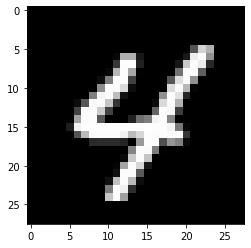

The pred result is  4


In [194]:
target_model.eval()
test_img,test_label=test_data[8222]
img = transforms.ToPILImage()(test_img).convert('RGB')
plt.imshow(img)
plt.show()
inputimg=Variable(torch.unsqueeze(test_img, 0)).cuda()
output = target_model(inputimg)
print("The pred result is ",output.argmax(1, keepdim=True).item())

## CK Attack based on l2 attack

In [275]:
def loss1_func(w,x,d,c):
    return torch.dist(x,(torch.tanh(w)*d+c),p=2)

def f(output,tlab,target,k=0):
    #f函数选用作者觉得最好的f6 f6(x)=max((max(Z(x')i)-Z(x')t),-k)
    real= torch.max(output*tlab)
    second=torch.max((1-tlab)*output)
    #如果指定了对象，则让这个更接近，否则选择第二个较大的
    if(target):
        return torch.max(second - real, torch.Tensor([-k]).cuda())
    else:
        return torch.max(real - second, torch.Tensor([-k]).cuda())

def cwattack_l2(img,model,right_label,iteration=1000,lr=0.001,target=False,target_label=0):
    shape=(1,3,28,28)
    binary_number=9                         #二分搜索
    maxc=1e10                               #从0.01-100去找c
    minc=0
    c=1e-3                                   #from c = 0:01 to c = 100 on the MNIST dataset.
    min_loss=1000000                         #找到最小的loss，即为方程的解
    min_loss_img=img                         #扰动后的图片
    k=0                                      #f函数使用，论文默认为0
    b_min = 0                                #盒约束，论文中使用了0-1 代码中-0.5 0.5
    b_max = 1
    b_mul=(b_max-b_min)/2.0
    b_plus=(b_min+b_max)/2.0
    tlab=Variable(torch.from_numpy(np.eye(10)[target_label]).cuda().float())
    for binary_index in range(binary_number):
        print("------------Start {} search, current c is {}------------".format(binary_index,c))
        
        #将img转换为w，w=arctanh(2x-1)，作为原始图片
        w = Variable(torch.from_numpy(np.arctanh((img.numpy()-b_plus)/b_mul*0.99999)).float()).cuda()
        
        w_pert=Variable(torch.zeros_like(w).cuda().float())
        w_pert.requires_grad = True
        #最初图像x
        x= Variable(img).cuda()
        optimizer = optim.Adam([w_pert], lr=lr) #论文p3选用Adam  
        isSuccessfulAttack=False
        
        for iteration_index in range(1,iteration+1):
            optimizer.zero_grad()
            
            # w加入扰动w_pert之后的新图像
            img_new=torch.tanh(w_pert+w)*b_mul+b_plus  #0.5*tanh(w+pert)+0.5
            loss_1=loss1_func(w,img_new,b_mul,b_plus)  #\\ deta\\  p=2
            model.eval()
            output=model(img_new)                      # Z(x)
            loss_2=c*f(output,tlab,target)             # c*f(x+deta) , x+deta=img_new, 
            loss=loss_1+loss_2                         # Minimize loss=loss1+loss2
            loss.backward(retain_graph=True)
            optimizer.step()
            if iteration_index%200==0:
                 print('Iters: [{}/{}]\tLoss: {},Loss1(L2 distance):{}, Loss2:{}'
                       .format(iteration_index,iteration,loss.item(),loss_1.item(),loss_2.item()))
                    
            pred_result=output.argmax(1, keepdim=True).item()
            #指定目标模式下,此处考虑l2距离最小,即找到最小的loss1
            if(target):
                if(min_loss>loss_1 and pred_result==target_label):
                    flag=False
                    for i in range(20):
                        output=model(img_new)
                        pred_result=output.argmax(1, keepdim=True).item()
                        if(pred_result!=target_label):
                            flag=True  #原模型中存在dropout，此处判断连续成功攻击20次，则视为有效
                            break
                    if(flag):
                        continue
                    min_loss=loss_1
                    min_loss_img=img_new
                    print('success when loss: {}, pred: {}'.format(min_loss,pred_result))
                    isSuccessfulAttack=True
             #非目标模式，找到最接近的一个,连续20次不预测成功
            else:
                if(min_loss>loss_1 and pred_result!=right_label):
                    flag=False
                    for i in range(50):
                        output=model(img_new)
                        pred_result=output.argmax(1, keepdim=True).item()
                        if(pred_result==right_label):
                            flag=True  #原模型中存在dropout，此处判断连续成功攻击50次，则视为有效
                            break
                    if(flag):
                        continue
                    min_loss=loss_1
                    min_loss_img=img_new
                    print('success when loss: {}, pred: {}'.format(min_loss,pred_result))
                    isSuccessfulAttack=True
        if(isSuccessfulAttack):
            maxc=min(maxc,c)
            if maxc<1e9: 
                c=(minc+maxc)/2
        #攻击失败，尝试放大c
        else:
            minc=max(minc,c)
            if(maxc<1e9):
                c=(maxc+minc)/2
            else:
                c=c*10
    return min_loss_img
                    

## Target Attack

In [261]:
victim_img=test_img
victim_label=test_label
print("Correct Label is ",victim_label)
victim_img_input = torch.unsqueeze(victim_img, 0)
attack_img = cwattack_l2(victim_img_input,target_model,victim_label,
                         iteration=1000,lr=0.01,target=True,target_label=3)

Correct Label is  4
------------Start 0 search, current c is 0.001------------
Iters: [200/1000]	Loss: 0.12186822295188904,Loss1(L2 distance):0.0012894130777567625, Loss2:0.1205788105726242
Iters: [400/1000]	Loss: 0.08808138966560364,Loss1(L2 distance):0.0013003161875531077, Loss2:0.0867810770869255
Iters: [600/1000]	Loss: 0.10146259516477585,Loss1(L2 distance):0.0015106415376067162, Loss2:0.09995195269584656
Iters: [800/1000]	Loss: 0.09266598522663116,Loss1(L2 distance):0.001421840745024383, Loss2:0.09124414622783661
Iters: [1000/1000]	Loss: 0.0763501301407814,Loss1(L2 distance):0.0012614545412361622, Loss2:0.07508867233991623
------------Start 1 search, current c is 0.01------------
Iters: [200/1000]	Loss: 1.282706379890442,Loss1(L2 distance):0.0014654701808467507, Loss2:1.2812409400939941
Iters: [400/1000]	Loss: 1.2063835859298706,Loss1(L2 distance):0.0013876252342015505, Loss2:1.2049959897994995
Iters: [600/1000]	Loss: 0.8543075919151306,Loss1(L2 distance):0.001146885217167437, Los

success when loss: 4.381809234619141, pred: 3
success when loss: 4.38122034072876, pred: 3
success when loss: 4.380630970001221, pred: 3
success when loss: 4.380041122436523, pred: 3
success when loss: 4.378859519958496, pred: 3
success when loss: 4.377675533294678, pred: 3
success when loss: 4.377082824707031, pred: 3
success when loss: 4.376489639282227, pred: 3
success when loss: 4.374110698699951, pred: 3
success when loss: 4.372917652130127, pred: 3
success when loss: 4.372320652008057, pred: 3
success when loss: 4.3699259757995605, pred: 3
success when loss: 4.369325637817383, pred: 3
success when loss: 4.368724822998047, pred: 3
success when loss: 4.368124008178711, pred: 3
success when loss: 4.367522239685059, pred: 3
success when loss: 4.366919994354248, pred: 3
success when loss: 4.366316795349121, pred: 3
success when loss: 4.365713596343994, pred: 3
success when loss: 4.365109920501709, pred: 3
success when loss: 4.364505290985107, pred: 3
success when loss: 4.3639001846313

success when loss: 4.239308834075928, pred: 3
success when loss: 4.238575458526611, pred: 3
success when loss: 4.237094402313232, pred: 3
success when loss: 4.235595703125, pred: 3
success when loss: 4.234840393066406, pred: 3
success when loss: 4.234082221984863, pred: 3
success when loss: 4.233320713043213, pred: 3
success when loss: 4.2325568199157715, pred: 3
success when loss: 4.231789588928223, pred: 3
success when loss: 4.231020450592041, pred: 3
success when loss: 4.227146148681641, pred: 3
success when loss: 4.22636604309082, pred: 3
success when loss: 4.225584983825684, pred: 3
success when loss: 4.224802494049072, pred: 3
success when loss: 4.223234176635742, pred: 3
success when loss: 4.222448825836182, pred: 3
success when loss: 4.221662521362305, pred: 3
success when loss: 4.220874786376953, pred: 3
success when loss: 4.220086097717285, pred: 3
success when loss: 4.219296932220459, pred: 3
success when loss: 4.218506813049316, pred: 3
success when loss: 4.216924667358398,

Iters: [600/1000]	Loss: 4.131500244140625,Loss1(L2 distance):4.131500244140625, Loss2:0.0
Iters: [800/1000]	Loss: 5.177277088165283,Loss1(L2 distance):4.009936332702637, Loss2:1.1673407554626465
Iters: [1000/1000]	Loss: 5.0258469581604,Loss1(L2 distance):3.795623540878296, Loss2:1.2302234172821045
------------Start 7 search, current c is 4.375------------
Iters: [200/1000]	Loss: 37.61029052734375,Loss1(L2 distance):4.017038822174072, Loss2:33.5932502746582
Iters: [400/1000]	Loss: 7.652139663696289,Loss1(L2 distance):4.403359413146973, Loss2:3.2487804889678955
Iters: [600/1000]	Loss: 4.495759010314941,Loss1(L2 distance):4.375761985778809, Loss2:0.11999711394309998
Iters: [800/1000]	Loss: 4.19511079788208,Loss1(L2 distance):4.19511079788208, Loss2:0.0
Iters: [1000/1000]	Loss: 3.9875810146331787,Loss1(L2 distance):3.9875810146331787, Loss2:0.0
------------Start 8 search, current c is 4.9375------------
Iters: [200/1000]	Loss: 43.94343185424805,Loss1(L2 distance):3.9645609855651855, Loss2:

## Attack Visualization

In [262]:
from tqdm import tqdm
def show3(ori,adv):
    plt.figure()
    plt.subplot(131)
    plt.title('Input Image')
    img1 = transforms.ToPILImage()(ori).convert('RGB')
    plt.imshow(img1)
    plt.subplot(132)
    plt.title('Adversarial Image')
    img2 =torch.tensor(adv).cpu()
    img2=torchvision.utils.make_grid(img2, normalize=True)
    Pert=img2-ori
    img2 = transforms.ToPILImage()(img2).convert('RGB')
    Pert = transforms.ToPILImage()(Pert).convert('RGB')
    plt.imshow(img2)
    plt.subplot(133)
    plt.title('Perturbation')
    plt.imshow(Pert)
    plt.show()


### 97.2% will be predicted as 3

F:\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


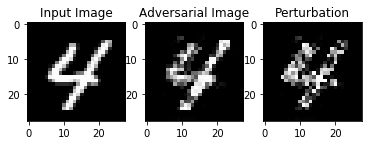

  2%|▏         | 41/2000 [00:00<00:04, 398.07it/s]

The pred result is  3


100%|██████████| 2000/2000 [00:05<00:00, 380.23it/s]

accuracy : 0.972


In [263]:
show3(victim_img,attack_img)
target_model.eval()
output = target_model(attack_img)
print("The pred result is ",output.argmax(1, keepdim=True).item())
sum_accuracy=0

for i in tqdm(range(2000)):
    output = target_model(attack_img)
    if(output.argmax(1, keepdim=True).item()==3):
        sum_accuracy+=1
print("accuracy :",sum_accuracy*1.0/2000)

## Untarget Attack

In [276]:
victim_img2,victim_label2=test_data[5652]
print("Correct Label is ",victim_label2)

victim_img_input2 = torch.unsqueeze(victim_img2, 0)
attack_untarget_img = cwattack_l2(victim_img_input2,target_model,victim_label2,
                         iteration=1000,lr=0.01)

Correct Label is  0
------------Start 0 search, current c is 0.001------------
Iters: [200/1000]	Loss: 0.04036024957895279,Loss1(L2 distance):0.0014036953216418624, Loss2:0.03895655274391174
Iters: [400/1000]	Loss: 0.027587514370679855,Loss1(L2 distance):0.001254626433365047, Loss2:0.02633288875222206
Iters: [600/1000]	Loss: 0.05724082142114639,Loss1(L2 distance):0.0007231129566207528, Loss2:0.05651770904660225
Iters: [800/1000]	Loss: 0.02826828509569168,Loss1(L2 distance):0.0015493110986426473, Loss2:0.026718974113464355
Iters: [1000/1000]	Loss: 0.030747290700674057,Loss1(L2 distance):0.0021142633631825447, Loss2:0.028633028268814087
------------Start 1 search, current c is 0.01------------
Iters: [200/1000]	Loss: 0.504010021686554,Loss1(L2 distance):0.0018962972098961473, Loss2:0.5021136999130249
Iters: [400/1000]	Loss: 0.3539573848247528,Loss1(L2 distance):0.0014158717822283506, Loss2:0.3525415062904358
Iters: [600/1000]	Loss: 0.47511130571365356,Loss1(L2 distance):0.001692387158982

### 无目标的随机攻击准确率相对较低（87%）可能来自于几个方面：
#### 1. 有目标攻击时，模型将集中收敛在一个特定区域，无目标攻击当识别结果不准确即判定成功，存在一定误差
#### 2. MNIST模型使用了dropout层，增强了原模型的鲁棒性
#### 3. MNIST数据集使用的是28 * 28像素图片，数据量较小，换为物体识别例如ImageNet会更好
#### 4. 测试训练环境为GTX 1650S，可以考虑提高迭代次数，降低学习率，提高判断成功的连续攻击次数

F:\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


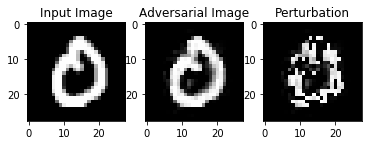

  2%|▏         | 39/2000 [00:00<00:05, 390.00it/s]

The pred result is  2


100%|██████████| 2000/2000 [00:05<00:00, 376.72it/s]

accuracy : 0.8685


In [279]:

show3(victim_img2,attack_untarget_img)
target_model.eval()
output = target_model(attack_untarget_img)
print("The pred result is ",output.argmax(1, keepdim=True).item())
sum_accuracy=0

for i in tqdm(range(2000)):
    output = target_model(attack_untarget_img)
    if(output.argmax(1, keepdim=True).item()!=0):
        sum_accuracy+=1
print("accuracy :",sum_accuracy*1.0/2000)
